# Practical Project - Business Process Management
### Enrico Lanza - 1603096

The primary objective of this project is to develop a predictive model that estimates the remaining time until the completion of an application process. Accurately forecasting this duration is crucial as it enables the provision of timely updates to applicants, enhancing transparency and efficiency. Such predictions can significantly improve the applicant's experience and operational planning.

This analysis utilizes the BPI Challenge 2018 dataset, which comprises records of applications submitted by German farmers for EU direct payments via the European Agricultural Guarantee Fund. The dataset provides a detailed chronology of each application's processing stages. For the purposes of this study, the conclusion of an application's last event is designated as the endpoint, thus setting the remaining time to zero at this stage.

The initial phase of the project involves a comprehensive examination of the dataset to understand the distribution of events and their characteristics. This analysis is crucial to designing appropriate preprocessing techniques that will facilitate effective model training.

Following the data analysis, we will implement two predictive models:
1. **Neural Network**: A neural network will be utilized to capture complex nonlinear patterns in the data, which may be indicative of the time remaining until the process completion.
2. **Tree-based Algorithm**: A tree-based algorithm, likely XGBoost or a similar model, will be employed to leverage its robustness in handling varied data types and its effectiveness in regression tasks.

Both models will be assessed based on their ability to predict the remaining time for each event in the application process using a regression framework. The performance of these models will be compared to identify the most effective approach in this context.


In [1]:
# First we will load the packages we need 
from BPM_utils import load_packages
load_packages()

Packages loaded successfully


In [2]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Related third party imports
import pm4py
import holidays
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from keras.models import load_model

# Local application/library specific imports
from BPM_utils import tune_NN_model_optuna
from BPM_utils import tune_XGB_model

C:\Users\lanza\AppData\Local\Temp\ipykernel_34080\1757343079.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 1. Preparation

### Data Source
The dataset employed in this study is sourced from the BPI Challenge 2018. Due to resource constraints, the dataset file is not included within this project repository. Interested researchers or participants can access and download the dataset from the following URL:

[**BPI Challenge 2018 Dataset**](https://data.4tu.nl/articles/dataset/BPI_Challenge_2018/12688355/1)

This dataset is curated by Boudewijn van Dongen and Florian Borchert (2018) and is hosted on 4TU.ResearchData. It provides a comprehensive account of applications for EU direct payments processed under the European Agricultural Guarantee Fund, as detailed by German administrative data. The dataset is publicly available and can be cited using the DOI: [10.4121/uuid:3301445f-95e8-4ff0-98a4-901f1f204972](https://doi.org/10.4121/uuid:3301445f-95e8-4ff0-98a4-901f1f204972).


In [3]:
#Load the data from the xes file and convert it to a dataframe (10 minutes)
path = 'BPI Challenge 2018.xes'
data_xes = pm4py.read_xes(path)    
data = pm4py.convert_to_dataframe(data_xes)
data.to_csv('BPI 2018.csv', index=False)


"\n#Load the data from the xes file and convert it to a dataframe (10 minutes)\npath = 'BPI Challenge 2018.xes'\ndata_xes = pm4py.read_xes(path)    \ndata = pm4py.convert_to_dataframe(data_xes)\ndata.to_csv('BPI 2018.csv', index=False)\n"

This code outputs an example path for an application. Since we will not use paths for the first part, we will simply convert the file into a data frame.

In [4]:
# Examine a specific trace
example_trace = data_xes[0]  # Taking the first trace for demonstration
for i in range(len(example_trace)-1):
    current_event = example_trace[i]
    next_event = example_trace[i+1]
    print(f"Current Event: {current_event['concept:name']}, Next Event: {next_event['concept:name']}")

'\n# Examine a specific trace\nexample_trace = data_xes[0]  # Taking the first trace for demonstration\nfor i in range(len(example_trace)-1):\n    current_event = example_trace[i]\n    next_event = example_trace[i+1]\n    print(f"Current Event: {current_event[\'concept:name\']}, Next Event: {next_event[\'concept:name\']}")\n'

In [5]:
# Read the data from the csv file
data = pd.read_csv('BPI 2018.csv')

# Display column names
print("Column names:")
print(data.columns)

Column names:
Index(['success', 'org:resource', 'docid_uuid', 'doctype', 'subprocess',
       'docid', 'activity', 'note', 'eventid', 'identity:id', 'concept:name',
       'lifecycle:transition', 'time:timestamp', 'case:young farmer',
       'case:selected_random', 'case:penalty_AJLP', 'case:application',
       'case:penalty_amount0', 'case:program-id', 'case:penalty_BGKV',
       'case:penalty_AUVP', 'case:applicant', 'case:risk_factor',
       'case:small farmer', 'case:penalty_BGP', 'case:department',
       'case:penalty_C16', 'case:penalty_BGK', 'case:penalty_AVUVP',
       'case:penalty_CC', 'case:penalty_AVJLP', 'case:penalty_C9',
       'case:cross_compliance', 'case:rejected', 'case:greening',
       'case:penalty_C4', 'case:penalty_AVGP', 'case:penalty_ABP',
       'case:penalty_B6', 'case:penalty_B4', 'case:penalty_B5',
       'case:penalty_AVBP', 'case:penalty_B2', 'case:selected_risk',
       'case:penalty_B3', 'case:area', 'case:selected_manually',
       'case:penalty_A

# 1.1 Preparation of timestamp

The main information we need for this task is the timestamp. Therfore we convert the column with this data to datatime. We will also include following resulting information:

- date : date of timestamp
- year : year of timestamp
- month : month of timestamp
- day : day of timestamp
- time : time of timestamp
- weekday: which weekday is the timestamp from (Monday=0, Tuesday=1, ..., Sunday=6)
- is_holiday: is this day a federal holiday in germany (boolean)

To execute the task we will need information about the remaining time of the application process. Therfor we will search for the latest event of each application and mark it with

- is_latest : boolean which is TRUE if it is the latest event of an application process
- remaining_time : time to the latest event in the process (in seconds)

In [6]:

# Identify rows where the timestamp column has the default value
default_timestamp = '1970-01-01T01:00:00+01:00'
mask = data['time:timestamp'] == default_timestamp
print("Number of rows with default timestamp: ", mask.sum())

# Convert the timestamp column to datetime
def convert_timestamp(ts):
    try:
        return pd.to_datetime(ts, format='%Y-%m-%d %H:%M:%S.%f%z')
    except ValueError:
        return pd.to_datetime(ts, format='%Y-%m-%d %H:%M:%S%z')
data['time:timestamp'] = data['time:timestamp'].apply(convert_timestamp)
data['time:timestamp'].describe()


Number of rows with default timestamp:  0


count                                2514266
mean     2016-10-21 20:53:28.748489216+00:00
min                2014-05-04 00:00:00+00:00
25%      2015-12-03 18:34:53.008500224+00:00
50%      2016-11-17 15:27:38.019500032+00:00
75%      2017-08-07 15:34:02.551000064+00:00
max                2018-01-19 13:03:02+00:00
Name: time:timestamp, dtype: object

In [7]:
# Sort the DataFrame by 'time:timestamp' and 'case:application'
data = data.sort_values(['case:application', 'time:timestamp'])

# Create a new column 'is_latest' that is True for the latest event of each application
data['is_latest'] = data.groupby('case:application')['time:timestamp'].transform(lambda x: x == x.max())

# Create a new column 'latest_time' that contains the timestamp of the latest event for each application
data['latest_time'] = data.groupby('case:application')['time:timestamp'].transform(max)

# Create a new column 'remaining_time' that contains the time from each event to the latest event of its application
data['remaining_time'] = data['latest_time'] - data['time:timestamp']

# Convert 'remaining_time' to seconds
data['remaining_time'] = data['remaining_time'].dt.total_seconds()

# Drop the 'latest_time' column
data = data.drop(columns=['latest_time'])

C:\Users\lanza\AppData\Local\Temp\ipykernel_34080\547872076.py:8: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data['latest_time'] = data.groupby('case:application')['time:timestamp'].transform(max)


In [8]:
german_holidays = holidays.Germany()

# Create a new column for the date (without time)
data['date'] = data['time:timestamp'].dt.date

# Create a new column 'time' that contains the time part of each timestamp
data['time'] = data['time:timestamp'].dt.time

# Create a new column 'weekday' that contains the day of the week
data['weekday'] = data['time:timestamp'].dt.day_name()

# Create a new column 'is_holiday' that indicates whether each date is a holiday
data['is_holiday'] = data['date'].apply(lambda x: x in german_holidays)

# Create a new column 'month' that contains the month of the year
data['month'] = data['time:timestamp'].dt.month

# Create a new column 'year' that contains the year
data['year'] = data['time:timestamp'].dt.year

# Create a new column 'day' that contains the day
data['day'] = data['time:timestamp'].dt.day

For the purpose of this task we will only watch at the events that are complete. For this project, a complete application is one that finishes with a payment. All other applications will be droped. We decided to drop all application that were not completed succefull (abortion or some kind of error) since this should be an exeption and we try to give a remaining time prediction for a normal applicant.

Now we will drop all applications where the last event is not of activity "finish payment".

In [9]:
# Get the number of unique applications before the drop
num_apps_before = data['case:application'].nunique()

# Get applications where the last event is not 'finish payment'
apps_not_finish_payment = data[(data['is_latest'] == 1) & (data['activity'] != 'finish payment')]['case:application']

# Drop the events of these applications
data = data[~data['case:application'].isin(apps_not_finish_payment)]

# Get the number of unique applications after the drop
num_apps_after = data['case:application'].nunique()

# Calculate the percentage of applications dropped
percent_dropped = (num_apps_before - num_apps_after) / num_apps_before * 100

print(f'{percent_dropped}% of applications were dropped.')

20.49578853660207% of applications were dropped.


## 1.2 Visualization of Data

First we want to see the events per day over the whold dataset

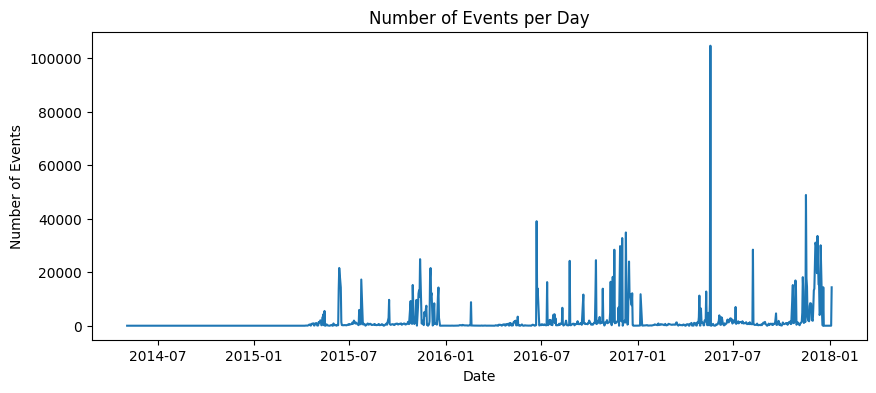

In [10]:
# Count the number of events for each day
events_per_day = data.groupby('date').size()

# Plot the number of events per day
events_per_day.plot(kind='line', figsize=(10,4))
plt.title('Number of Events per Day')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.show()

We seem to see that there are some periodic trends within our dataset

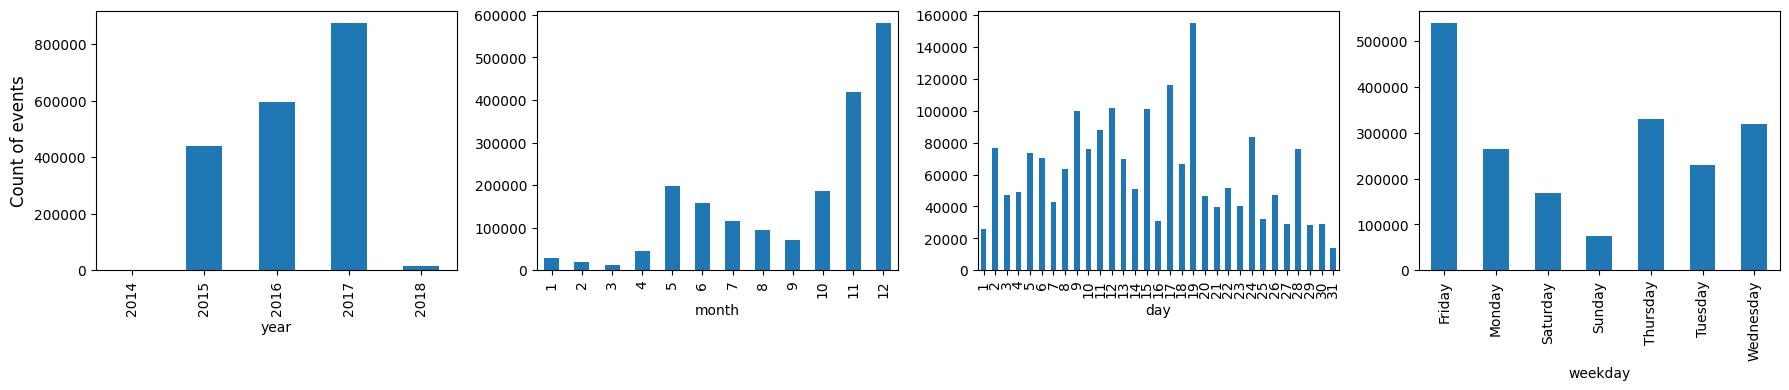

In [11]:
fs = 12
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

# Order the weekdays
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for col, col_name in enumerate(['year', 'month', 'day', 'weekday']):
    data.groupby(col_name).size().plot(kind='bar', ax=axes[col], legend=False)
    
axes[0].set_ylabel('Count of events', fontsize=fs)

fig.tight_layout()
plt.show()

As expected, on weekends significantly less events are processed. Also if there is holidays, nearly no events are processed. This confirms the assumption that weekends are significant for this dataset.

What is also interesting to see ist that most events seem to happen at the end of each year. This makes sense if we assume that the payment to the farmer is on a yearly basis and the farmers tend to apply at the end of the year. We also have an increase in the middle of the year, it seems like some applications may be on a half-year basis. 



### 1.3 Preprocessing for ML

In [12]:
data['time:timestamp'] = pd.to_datetime(data['time:timestamp']).astype('int64') / 10**9
data['time'] = data['time'].apply(lambda t: t.hour*3600 + t.minute*60 + t.second)

# Iterate over each column
for column in data.columns:
    # Check if the column is non-numerical and has less than 50 unique values
    if data[column].dtype == 'object' and data[column].nunique() < 50:
        # One-hot encode the column and drop the original column
        data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
        data.drop([column], axis=1, inplace=True)
    else:
        # Factorize the column
        data[column] = pd.factorize(data[column])[0]

# Print the new data types of the columns
print(data.dtypes)

success              int64
org:resource         int64
docid_uuid           int64
docid                int64
eventid              int64
                     ...  
weekday_Saturday      bool
weekday_Sunday        bool
weekday_Thursday      bool
weekday_Tuesday       bool
weekday_Wednesday     bool
Length: 201, dtype: object


In [13]:
# Translate all boolean columns to integers
for col in data.columns:
    if data[col].dtype == 'bool':
        data[col] = data[col].astype(int)

### 1.4 Selection of Features

In [14]:
import numpy as np
import seaborn as sns

# Calculate correlation
corr = data.corr()

# Set correlation threshold
threshold = 0.1

# Select only correlations for "remaining_time"
corr_remaining_time = corr['remaining_time']

# Create a mask for values above the threshold
mask = np.abs(corr_remaining_time) > threshold

# Apply the mask to the correlations
significant_corr_remaining_time = corr_remaining_time[mask]

# Remove NaN values
significant_corr_remaining_time.dropna(inplace=True)

# Convert Series to DataFrame for heatmap compatibility
significant_corr_remaining_time = significant_corr_remaining_time.to_frame()

# Plot the heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(significant_corr_remaining_time, annot=True, annot_kws={'fontsize': 10}, fmt='.2f', ax=ax)

Here we try to see the significance between remaining_time and other features. Due to the amount of features we filter with a threshold (0.1) and only show the significance between remaining_time and features.

Remarkable is that there are multiple significant correlations between the remaining time and penalties. Not suprisingly there is also a correlation between actual payment and remaining_time, since when the payment happens this indicates that the process goes to an end. As already seen earlier there is a high correlation between year and remeining time since it seems like many applications are processed at the end of the year. 

# 2. Predictions

First of all we split into train, val and test set.

In [ ]:
from sklearn.model_selection import train_test_split

# Get a list of unique applications
applications = data['case:application'].unique()

# Split the applications into train, validation, and test sets
train_apps, test_apps = train_test_split(applications, test_size=0.2, random_state=42)
train_apps, val_apps = train_test_split(train_apps, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Use the lists of applications to split the data into train, validation, and test sets
train_data = data[data['case:application'].isin(train_apps)]
val_data = data[data['case:application'].isin(val_apps)]
test_data = data[data['case:application'].isin(test_apps)]

In [ ]:
import pickle

with open('train_val_test.pkl', 'wb') as f:
    pickle.dump((train_data, val_data, test_data), f)

### 2.1 Prediction with Keras

Now we will try to predict the remaining time of an event with a simple Keras Regressor that we optimize with Optuna. For this we only use the single event logs without any sequence information. We use 133333 data points (100000 train set, 33333 val set).

If you want to run the training of the ANN model and the following XGB model, use the BPM.py file to do so.

(Remark: even on the bwhpc server this takes some time on one node, we didnt had the time to train the model on the full dataset)

In [20]:
import pickle
import numpy as np
with open('train_val_test.pkl', 'rb') as f:
    train_data, val_data, test_data = pickle.load(f)

# Define the features and target
X_train = np.array(train_data.drop(columns=['remaining_time']))
y_train = np.array(train_data['remaining_time'])
X_val = np.array(val_data.drop(columns=['remaining_time']))
y_val = np.array(val_data['remaining_time'])
X_test = np.array(test_data.drop(columns=['remaining_time']))
y_test = np.array(test_data['remaining_time'])

In [21]:
# Select the first 97 samples for testing to make it comparable to later models
X_test = X_test[:97]
y_test = y_test[:97]

In [22]:
#ann_model, ann_params, status = tune_NN_model_optuna(X_train, y_train, X_val, y_val)
#ann_model.save('ann_model.h5') 

In [23]:
# Make predictions using the ANN model
from keras.models import load_model
ann_model = load_model('ann_model_v2.h5')
ann_prediction = ann_model.predict(X_test)

4/4 [==============================] - 0s 6ms/step


### 2.2 Prediction with XGBoost



To compare our results of the simple KerasRegressor, we also train a basic XGB model on the data. Still we dont use any sequence data and used 133333 data points (100000 train set, 33333 val set) out of resource limitations.

(Remark: even on the bwhpc server this takes some time on one node, we didnt had the time to train the model on the full dataset)

In [24]:
#xgb_model, xgb_params, status = tune_XGB_model(X_train, y_train, X_val, y_val)
#xgb_model.save_model('xgb_model.json')

In [25]:
# Make predictions using the XGB model
import xgboost as xgb
xgb_model = xgb.Booster()
xgb_model.load_model('xgb_model_v2.json')
xgb_prediction = xgb_model.predict(xgb.DMatrix(X_test))

### 2.3 Evaluation of Prediction based on single events

We used an ANN and XGBoost to predict the remaining time of events in application processes while only using single events for training.

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming you have the true labels in y_test and your predictions in xgb_prediction and ann_prediction
xgb_mse = mean_squared_error(y_test, xgb_prediction)
ann_mse = mean_squared_error(y_test, ann_prediction)

xgb_rmse = np.sqrt(xgb_mse)
ann_rmse = np.sqrt(ann_mse)

xgb_mae = mean_absolute_error(y_test, xgb_prediction)
ann_mae = mean_absolute_error(y_test, ann_prediction)

xgb_r2 = r2_score(y_test, xgb_prediction)
ann_r2 = r2_score(y_test, ann_prediction)

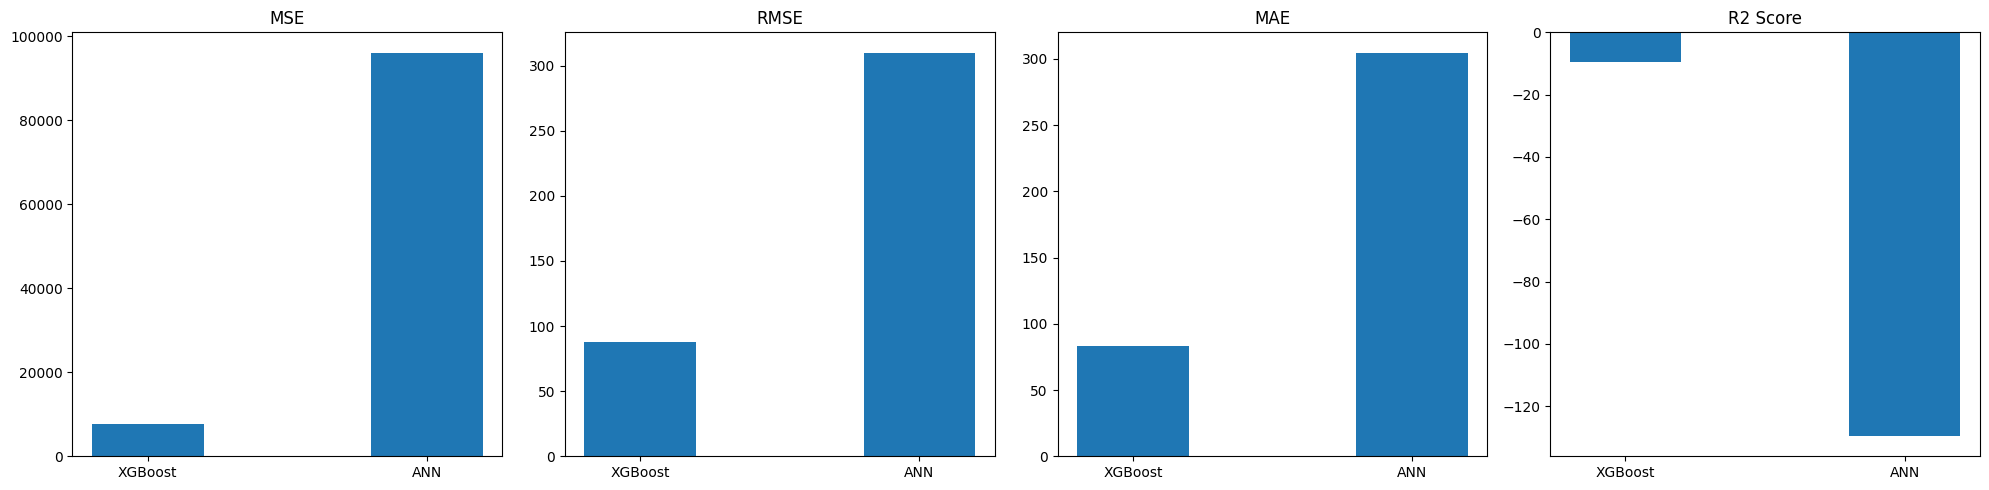

In [27]:
import matplotlib.pyplot as plt

# Metrics
metrics = ['MSE', 'RMSE', 'MAE', 'R2 Score']

# XGBoost values
xgb_values = [xgb_mse, xgb_rmse, xgb_mae, xgb_r2]

# ANN values
ann_values = [ann_mse, ann_rmse, ann_mae, ann_r2]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Loop through each metric and plot
for i, metric in enumerate(metrics):
    axs[i].bar(['XGBoost', 'ANN'], [xgb_values[i], ann_values[i]], width=0.4)
    axs[i].set_title(metric)

# Display the plot
plt.tight_layout()
plt.show()

As we can see the XGBoost model outperforms the ANN model in all evaluation metrics. Here are a few reasons why our XGBoost might outperform the ANN for predicting the remaining time for events in an application process using only data of single events:

- Handling of Tabular Data: XGBoost is a tree-based model, which often performs better on structured, tabular data. ANNs can also handle this type of data, but they often require more complex architectures and more data to perform well.

- Feature Interactions: XGBoost inherently captures interactions between features through its tree structure. In contrast, ANNs require specific architectures (like deep networks) to capture these interactions, which can make them more complex and computationally expensive.

# 4. LSTM Model

Obviously, our previous approach does not exploit the full potential of the data as it does not utilize the information about the paths.

As shown in the lecture and the literature (Verenich et al.), LSTM seems to be the most promising approach. So our next approach is to use LSTM and compare the results with our previous approach. By doing so, we want to see how much our prediction improves.

@article{Verenich et al.,
author = {Verenich, Ilya and Dumas, Marlon and La Rosa, Marcello and Maggi, Fabrizio and Teinemaa, Irene},
year = {2019},
month = {07},
pages = {1-34},
title = {Survey and Cross-benchmark Comparison of Remaining Time Prediction Methods in Business Process Monitoring},
volume = {10},
journal = {ACM Transactions on Intelligent Systems and Technology},
doi = {10.1145/3331449}
}

### 4.1 LSTM Training

We trained the LSTM model using optuna hyperparameter optimization. We utilized 1333 sequence data points (1000 trains set, 333 val set). Each sequence consists of 3 events.

If you want to run the training by yourself, use the BPM_series.py file. It will use the train_val_test.pkl to create the sequenced and lagged Data and train the model accordingly.

(Remark: even on the bwhpc server this takes some time on one node, we didnt had the time to train the model on the full dataset)

In [28]:
# Load the sequence data
import pickle
with open('sequence_data.pkl', 'rb') as f:
    X_train_sequence, X_val_sequence, X_test_sequence, y_train_sequence, y_val_sequence, y_test_sequence = pickle.load(f)
print("Sequence data loaded")

Sequence data loaded


In [29]:
from keras.models import load_model
lstm_model = load_model('lstm_series_model_v2.h5')
lstm_prediction = lstm_model.predict(X_test_sequence)
print (lstm_prediction[1])

4/4 [==============================] - 0s 0s/step
[341.0684]


### 4.2 Evaluation of LSTM

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming you have the true labels in y_test and your predictions in xgb_prediction and ann_prediction
xgb_mse = mean_squared_error(y_test, xgb_prediction)
ann_mse = mean_squared_error(y_test, ann_prediction)
lstm_mse = mean_squared_error(y_test, lstm_prediction)

xgb_rmse = np.sqrt(xgb_mse)
ann_rmse = np.sqrt(ann_mse)
lstm_rmse = np.sqrt(lstm_mse)

xgb_mae = mean_absolute_error(y_test, xgb_prediction)
ann_mae = mean_absolute_error(y_test, ann_prediction)
lstm_mae = mean_absolute_error(y_test, lstm_prediction)

xgb_r2 = r2_score(y_test, xgb_prediction)
ann_r2 = r2_score(y_test, ann_prediction)
lstm_r2 = r2_score(y_test, lstm_prediction)

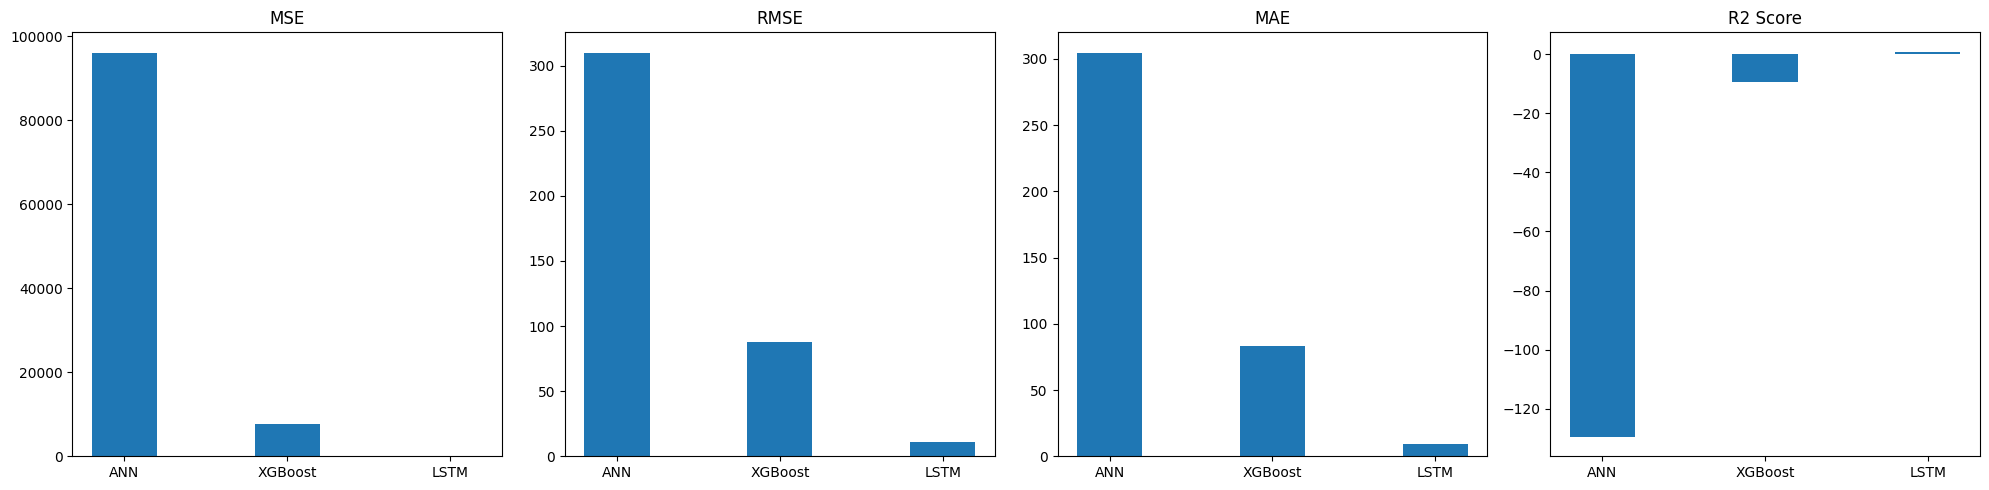

In [31]:
import matplotlib.pyplot as plt

# Metrics
metrics = ['MSE', 'RMSE', 'MAE', 'R2 Score']

# XGBoost values
xgb_values = [xgb_mse, xgb_rmse, xgb_mae, xgb_r2]

# ANN values
ann_values = [ann_mse, ann_rmse, ann_mae, ann_r2]

# LSTM values
lstm_values = [lstm_mse, lstm_rmse, lstm_mae, lstm_r2]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Loop through each metric and plot
for i, metric in enumerate(metrics):
    axs[i].bar(['ANN', 'XGBoost', 'LSTM'], [ann_values[i], xgb_values[i], lstm_values[i]], width=0.4)
    axs[i].set_title(metric)

# Display the plot
plt.tight_layout()
plt.show()

As expected our LSTM model performs way better than the other two models, resulting of the use of sequence data.

# 5. Combining LSTM and XGBoost

In this chapter we want to combine XGBoost and LSTM to even improve the results of LSTM (based on the paper of He & Yu from 2020)

Combining XGBoost and Long Short-Term Memory (LSTM) models for predicting remaining times in business process management (BPM) leverages the unique strengths of both model types to improve prediction accuracy. Here's why these models are effective together and how they can be integrated:

### Strengths of XGB and LSTM in BPM Context
- **XGBoost (XGB)**: This model excels with structured data, capturing complex relationships and interactions between variables. It effectively handles attributes of a process like task completion rates and resource usage, influencing predictions of remaining times.
  
- **Long Short-Term Memory (LSTM)**: As a type of recurrent neural network, LSTMs excel at modeling sequences and time-series data. In BPM, where the order and timing of events significantly affect outcomes, LSTMs can capture temporal dependencies that are less apparent to tree-based models like XGB.

### Implementing XGB and LSTM Combination for BPM
The combination of XGB and LSTM for predicting remaining times in processes combines structured data analysis with sequence modeling, offering a comprehensive approach.

#### Benefits of Combining XGB and LSTM:
- **Comprehensive Data Utilization**: This approach uses both structured and unstructured data, with XGB analyzing cross-sectional data points and LSTM processing temporal sequence data.
- **Enhanced Accuracy and Robustness**: By smoothing out individual model weaknesses and exploiting their strengths, this combined approach can lead to more stable and accurate predictions across different conditions.
- **Adaptive Performance**: The reciprocal error weighting adjusts the influence of each model based on its performance, dynamically adapting to the data at hand.

@article{He&Yu,
author = {He, Zhang and Yu, Sun},
year = {2020},
month = {12},
pages = {012110},
title = {Application of LightGBM and LSTM combined model in vegetable sales forecast},
volume = {1693},
journal = {Journal of Physics: Conference Series},
doi = {10.1088/1742-6596/1693/1/012110}
}

### 5.1 XGBoost based on Data with lagged Features

To combine LSTM with XGBoost we want to enhance our XGBoost model through using Data with lagged features (so we also utilize the sequence of our data). Therefor we created Data witch includes the features of the two previous steps of each event. We trained the XGBoost on the same sequences as our LSTM model.

In [32]:
# Load the sequence data
import pickle
with open('lagged_data.pkl', 'rb') as f:
    X_train_lagged, X_val_lagged, X_test_lagged, y_train_lagged, y_val_lagged, y_test_lagged = pickle.load(f)
print("Sequence data loaded")

Sequence data loaded


In [33]:
import xgboost as xgb

# Load the model
xgb_model = xgb.Booster()
xgb_model.load_model('xgb_series_model_v2.json')
xgb_lagged_prediction = xgb_model.predict(xgb.DMatrix(X_test_lagged))
print (xgb_lagged_prediction[1])

393.9534


### 5.2 Combination of XGBoost and LSTM 

We use a bit simplified version of the proposed approach of He & Yu

In [34]:
lstm_val_prediction = lstm_model.predict(X_val_sequence)
xgb_lagged_val_prediction = xgb_model.predict(xgb.DMatrix(X_val_lagged))

3/3 [==============================] - 0s 2ms/step


In [74]:
lstm_val_prediction = lstm_val_prediction.ravel()
y_val_sequence = y_val_sequence.ravel()
y_val_lagged = y_val_lagged.ravel()


First, compute the errors for each model (mse). We use the validation data set to not compromise our results. 

In [36]:
from sklearn.metrics import mean_squared_error

# Calculate errors
error_xgb = mean_squared_error(y_val_lagged, xgb_lagged_val_prediction)
error_lstm = mean_squared_error(y_val_sequence, lstm_val_prediction)
print("XGBoost Error:", error_xgb)
print("LSTM Error:", error_lstm)


XGBoost Error: 34236.60115612243
LSTM Error: 174.31337046803353


The next step is to calculate the reciprocal of these errors. The reciprocal transforms the error such that a lower error (better performance) results in a higher weight.

In [37]:
reciprocal_error_xgb = 1 / error_xgb
reciprocal_error_lstm = 1 / error_lstm
print("Reciprocal Error GBM:", reciprocal_error_xgb)
print("Reciprocal Error LSTM:", reciprocal_error_lstm)

Reciprocal Error GBM: 2.9208506867837055e-05
Reciprocal Error LSTM: 0.005736794586181128


To ensure that the weights sum to 1, we normalize these reciprocal values.

In [38]:
sum_reciprocal_errors = reciprocal_error_xgb + reciprocal_error_lstm
weight_xgb = reciprocal_error_xgb / sum_reciprocal_errors
weight_lstm = reciprocal_error_lstm / sum_reciprocal_errors
print("Weight XGB:", weight_xgb)
print("Weight LSTM:", weight_lstm)

Weight XGB: 0.005065641900721231
Weight LSTM: 0.9949343580992788


Finally, we apply these weights to the predictions from each model to get the final combined prediction.

In [50]:
xgb_lagged_prediction = xgb_lagged_prediction[:97]
lstm_prediction = lstm_prediction.ravel()
y_pred_combined = (xgb_lagged_prediction * weight_xgb) + (lstm_prediction * weight_lstm)

# 6. Evaluation

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming you have the true labels in y_test and your predictions in xgb_prediction and ann_prediction
xgb_mse = mean_squared_error(y_test, xgb_prediction)
ann_mse = mean_squared_error(y_test, ann_prediction)
lstm_mse = mean_squared_error(y_test, lstm_prediction)
xgb_lstm_mse = mean_squared_error(y_test, y_pred_combined)
xgb_lagged_mse = mean_squared_error(y_test, xgb_lagged_prediction)

xgb_rmse = np.sqrt(xgb_mse)
ann_rmse = np.sqrt(ann_mse)
lstm_rmse = np.sqrt(lstm_mse)
xgb_lstm_rmse = np.sqrt(xgb_lstm_mse)
xgb_lagged_rmse = np.sqrt(xgb_lagged_mse)

xgb_mae = mean_absolute_error(y_test, xgb_prediction)
ann_mae = mean_absolute_error(y_test, ann_prediction)
lstm_mae = mean_absolute_error(y_test, lstm_prediction)
xgb_lstm_mae = mean_absolute_error(y_test, y_pred_combined)
xgb_lagged_mae = mean_absolute_error(y_test, xgb_lagged_prediction)


xgb_r2 = r2_score(y_test, xgb_prediction)
ann_r2 = r2_score(y_test, ann_prediction)
lstm_r2 = r2_score(y_test, lstm_prediction)
xgb_lstm_r2 = r2_score(y_test, y_pred_combined)
xgb_lagged_r2 = r2_score(y_test, xgb_lagged_prediction)

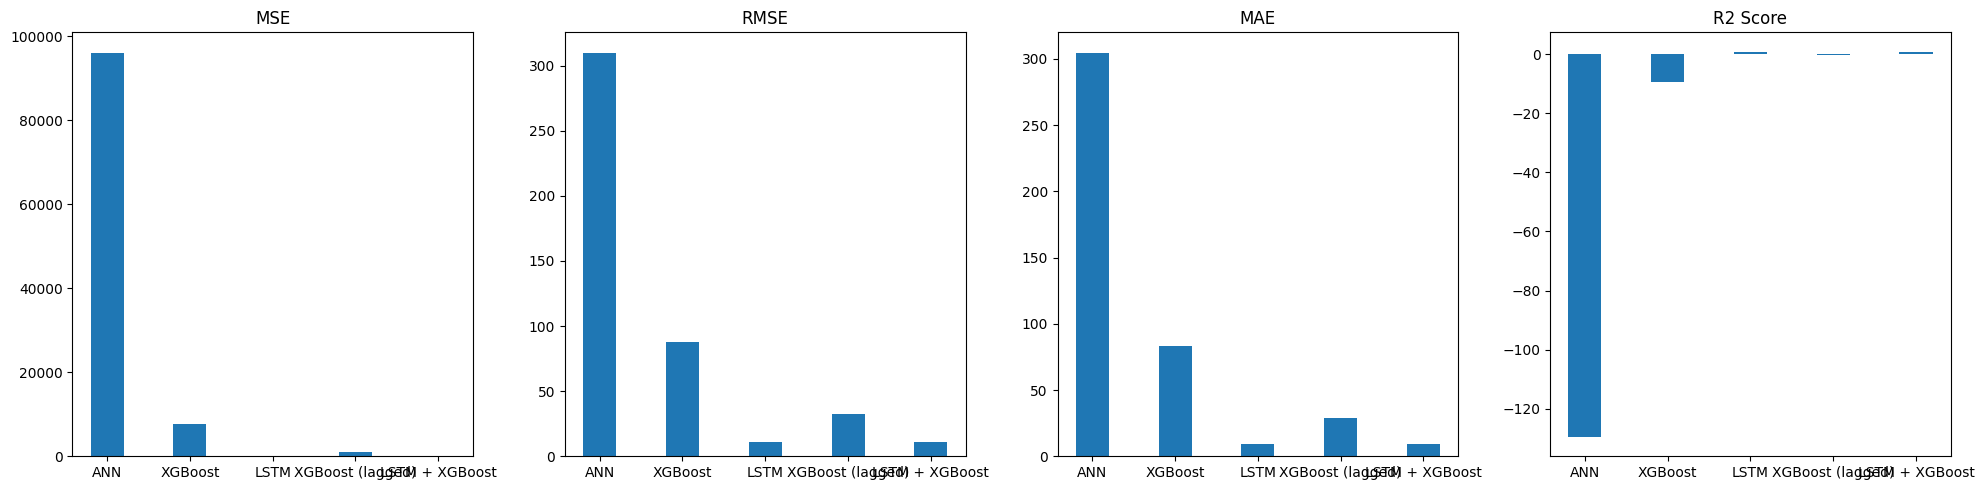

In [53]:
import matplotlib.pyplot as plt

# Metrics
metrics = ['MSE', 'RMSE', 'MAE', 'R2 Score']

# XGBoost values
xgb_values = [xgb_mse, xgb_rmse, xgb_mae, xgb_r2]

# ANN values
ann_values = [ann_mse, ann_rmse, ann_mae, ann_r2]

# LSTM values
lstm_values = [lstm_mse, lstm_rmse, lstm_mae, lstm_r2]

# XGB LSTM values
xgb_lstm_values = [xgb_lstm_mse, xgb_lstm_rmse, xgb_lstm_mae, xgb_lstm_r2]

# XGB Lagged values
xgb_lagged_values = [xgb_lagged_mse, xgb_lagged_rmse, xgb_lagged_mae, xgb_lagged_r2]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Loop through each metric and plot
for i, metric in enumerate(metrics):
    axs[i].bar(['ANN', 'XGBoost', 'LSTM', 'XGBoost (lagged)', 'LSTM + XGBoost'], [ann_values[i], xgb_values[i], lstm_values[i], xgb_lagged_values[i], xgb_lstm_values[i]], width=0.4)
    axs[i].set_title(metric)

# Display the plot
plt.tight_layout()
plt.show()

As expected the XGBoost model using the lagged Features outperforms the normal XGBoost.

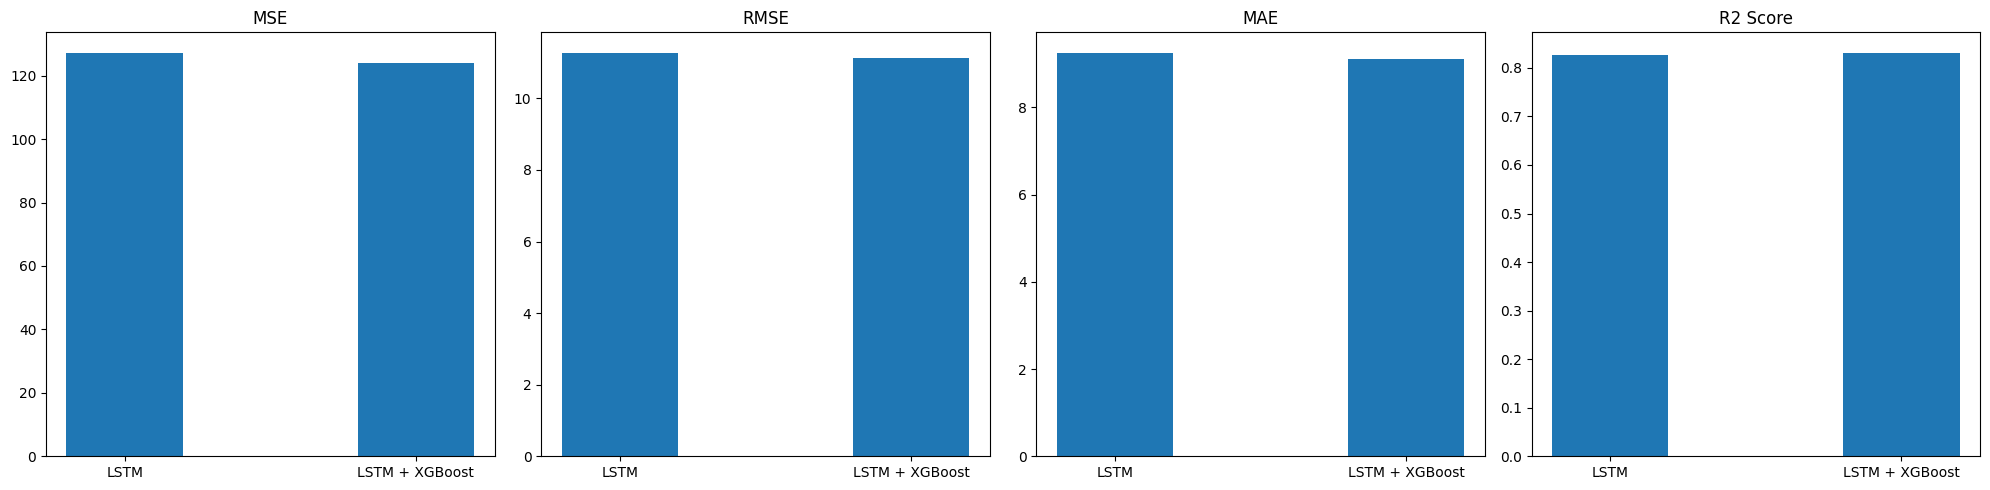

LSTM MSE: 127.29513516626561
Combined MSE: 123.91569554261363
LSTM RMSE: 11.282514576381704
Combined RMSE: 11.131742700162164
LSTM MAE: 9.259688229904961
Combined MAE: 9.12166540401498
LSTM R2 Score: 0.8270787596702576
Combined R2 Score: 0.8316695094108582


In [56]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Loop through each metric and plot
for i, metric in enumerate(metrics):
    axs[i].bar(['LSTM', 'LSTM + XGBoost'], [lstm_values[i], xgb_lstm_values[i]], width=0.4)
    axs[i].set_title(metric)

# Display the plot
plt.tight_layout()
plt.show()

print("LSTM MSE:", lstm_mse)
print("Combined MSE:", xgb_lstm_mse)
print("LSTM RMSE:", lstm_rmse)
print("Combined RMSE:", xgb_lstm_rmse)
print("LSTM MAE:", lstm_mae)
print("Combined MAE:", xgb_lstm_mae)
print("LSTM R2 Score:", lstm_r2)
print("Combined R2 Score:", xgb_lstm_r2)

As claimed by He & Yu, the combination of LSTM and XGBoost slightly outperforms the normal LSTM model in all metrics. Even though the XGBoost model using lagged Features performs way worse than the LSTM model. Even though in this case it is just a very slight benefit, it is possible that this advantage increases with more data and more sequences.

One main reason for this "low" improvement is definitly the bad performance of the XGBoost on the lagged Feature data, if we could improve this result than we could improve the combined model.

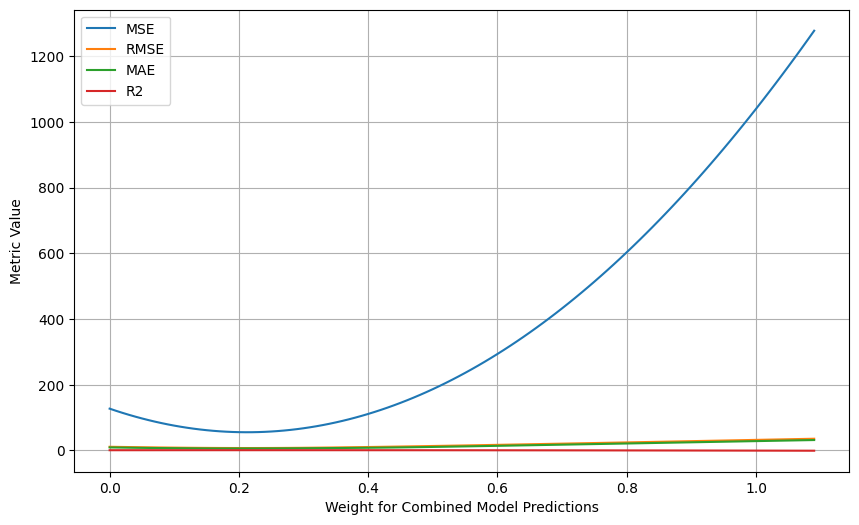

In [73]:
import matplotlib.pyplot as plt

# Define the range of weights
weights = np.arange(0, 1.1, 0.01)

# Initialize lists to store the results
mse_values = []
rmse_values = []
mae_values = []
r2_values = []

# Loop over the weights
for weight in weights:
    # Calculate the combined predictions
    y_pred_combined = (xgb_lagged_prediction * weight) + (lstm_prediction * (1 - weight))
    
    # Calculate the metrics
    mse = mean_squared_error(y_test, y_pred_combined)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_combined)
    r2 = r2_score(y_test, y_pred_combined)
    
    # Store the results
    mse_values.append(mse)
    rmse_values.append(rmse)
    mae_values.append(mae)
    r2_values.append(r2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(weights, mse_values, label='MSE')
plt.plot(weights, rmse_values, label='RMSE')
plt.plot(weights, mae_values, label='MAE')
plt.plot(weights, r2_values, label='R2')
plt.xlabel('Weight for Combined Model Predictions')
plt.ylabel('Metric Value')
plt.legend(loc='best')
plt.grid()
plt.show()

In [71]:
# Find the index of the minimum value for each metric
min_mse_index = np.argmin(mse_values)
min_rmse_index = np.argmin(rmse_values)
min_mae_index = np.argmin(mae_values)
min_r2_index = np.argmax(r2_values) 

# Find the weight that gives the minimum value for each metric
min_mse_weight = weights[min_mse_index]
min_rmse_weight = weights[min_rmse_index]
min_mae_weight = weights[min_mae_index]
min_r2_weight = weights[min_r2_index] 

print(f'Weight for minimum MSE: {min_mse_weight}')
print(f'Weight for minimum RMSE: {min_rmse_weight}')
print(f'Weight for minimum MAE: {min_mae_weight}')
print(f'Weight for minimum R2: {min_r2_weight}')

Weight for minimum MSE: 0.21
Weight for minimum RMSE: 0.21
Weight for minimum MAE: 0.2
Weight for minimum R2: 0.21


It seems like a weight of 0.21 for the xgb lagged prediction would result in the best outcome

In [ ]:
y_pred_custom = (xgb_lagged_prediction * min_mse_weight) + (lstm_prediction * (1 - min_mse_weight))

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate the metrics
mse_custom = mean_squared_error(y_test, y_pred_custom)
rmse_custom = np.sqrt(mse_custom)
mae_custom = mean_absolute_error(y_test, y_pred_custom)
r2_custom = r2_score(y_test, y_pred_custom)

custom_values = [mse_custom, rmse_custom, mae_custom, r2_custom]

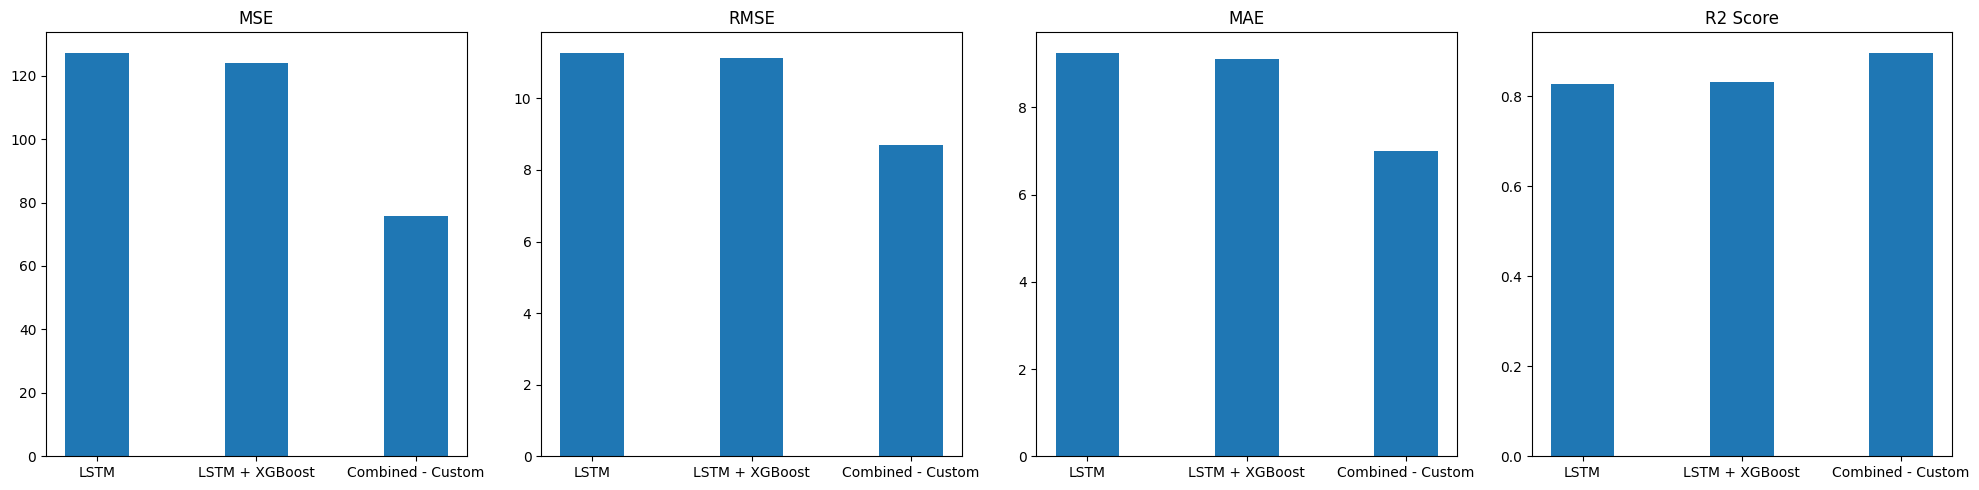

In [72]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Loop through each metric and plot
for i, metric in enumerate(metrics):
    axs[i].bar(['LSTM', 'LSTM + XGBoost', 'Combined - Custom'], [lstm_values[i], xgb_lstm_values[i], custom_values[i]], width=0.4)
    axs[i].set_title(metric)

# Display the plot
plt.tight_layout()
plt.show()

With this change for the weights of the combined model we can significantly improve the performance compared to the LSTM model.

With a bigger size of the validation data set (we calculated the weights on), it is possible that the result would be near to this more optimal solution.

# 7. Outlook

Obvious steps to improve the results and further prove the statement of He & Yu are:

- use the full dataset for training of the ML models
- use more events per sequence, so make the sequences bigger
- use more time for feature extraction and data preprocessing

Further steps for evaluating and explaining the good performance of the LSTM + XGBoost model are:

- examine in which aspects the XGBoost improves the LSTM
- examine what kind of data is beneficial for the performance lead of the combined model
